## Importy

In [1]:
import os
import time
import random
from enum import Enum

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import display, clear_output
from PIL import Image, ImageDraw, ImageFont

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

# Przygotowanie środowiska

Celem projektu jest stworzenie środowiska odwzorowującego Safari Zone w grze Pokemon. Celem agenta będzie złapanie jak największej ilości pokemonów z ograniczoną liczbą Safari Ball.

## Akcje agenta

Agent będzie miał do wyboru 3 akcje:

Catch - rzucenie i stracenie Safari Ball w celu podjęcia próby złapania pokemona.

Rock - rzucenie kamienia, który zwiększy szanse na złapanie, ale również na ucieczke pokemona.

Bait - rzucenie przynęty, która zmniejszy szanse uciekczki, ale również zmniejszy szanse złapania pokemona.


Akcje zostały zaimplementowane jako enum.

In [2]:
class TrainerAction(Enum):
    CATCH = 0
    ROCK = 1
    BAIT = 2

## Gatunek pokemona

Pokemony pojawiające się w środowisku będą podzielone na kilka rodzajów. W zależności od rodzaju Pokémona będzie on posiadał różne wartości statystyk. Do statystyk pokemonów należą: szansa na złapanie, szansa na ucieczke, level oraz mnożniki skuteczności rock i bait. W zależności od statystyk agent będzie musiał przyjąć inne strategie.

In [3]:
class PokemonType(Enum):
    PIKACHU = ("Pikachu", 0.4, 0.15, 1.1, 0.9, 7, 5, 15)
    ABRA = ("Abra", 0.2, 0.4, 0.8, 1.5, 4, 10, 20)
    SNORLAX = ("Snorlax", 0.1, 0.05, 1.5, 0.7, 10, 25, 35)
    CHARMANDER = ("Charmander", 0.3, 0.2, 1.0, 1.0, 8, 12, 22)
    MAGIKARP = ("Magikarp", 0.8, 0.3, 0.9, 1.1, 5, 2, 10)

    def __init__(self, name, base_catch_rate, base_escape_rate, bait_effect_multiplier, rock_effect_multiplier, base_turns, min_level, max_level):
        self.pokemon_name = name
        self.base_catch_rate = base_catch_rate
        self.base_escape_rate = base_escape_rate
        self.bait_effect_multiplier = bait_effect_multiplier
        self.rock_effect_multiplier = rock_effect_multiplier
        self.base_turns = base_turns
        self.min_level = min_level
        self.max_level = max_level

    def __str__(self):
        return f"{self.pokemon_name} (Lvl: {self.min_level}-{self.max_level})"

## Encounter

Klasa WildPokemon odpowiada za logikę spotkań między Agentem, a Pokemonami. Klasa bierze pokemona i jego podstawowe statystyki, przelicza je w celu zwiększenia lub zmniejszenia trudności złapania w zależności od levelu (większy level -> większa trudność). W zależności od akcji agenta klasa zwiekszy lub zmniejszy statystyki i zdeterminuje czy pokemon został złapany czy uciekł.

In [4]:
class WildPokemon:
    def __init__(self, pokemon_type: PokemonType):
        self.pokemon_type = pokemon_type
        self.level = random.randint(pokemon_type.min_level, pokemon_type.max_level)
        
        self.current_catch_rate = self._calculate_initial_catch_rate()
        self.current_escape_rate = self._calculate_initial_escape_rate()
        
        self.remaining_turns = pokemon_type.base_turns
        self.turns_elapsed_in_encounter = 0
        self.baits_thrown = 0
        self.rocks_thrown = 0
        
    def _calculate_initial_catch_rate(self): #Obliczanie bazowej szansy na złapanie
        level_penalty = (self.level - self.pokemon_type.min_level) * 0.01 
        return max(0.01, self.pokemon_type.base_catch_rate - level_penalty) 

    def _calculate_initial_escape_rate(self): #Obliczanie bazowej szansy na ucieczke
        level_bonus = (self.level - self.pokemon_type.min_level) * 0.005 
        return min(0.99, self.pokemon_type.base_escape_rate + level_bonus) 

    def perform_action(self, action: TrainerAction) -> tuple[bool, bool]: #Zmienianie wartości statystyk w zależności od akcji
        self.remaining_turns -= 1
        self.turns_elapsed_in_encounter += 1
        
        caught = False
        escaped = False

        if action == TrainerAction.BAIT:
            # BAIT: Zmniejsza szansę na ucieczkę, ale odrobinę zmniejsza szansę na złapanie
            # Zmniejszenie szansy na ucieczkę (im wyższy level, tym mniejszy wpływ)
            escape_decrease_amount = 0.05 * (1 - (self.level / 100.0)) * self.pokemon_type.bait_effect_multiplier
            self.current_escape_rate = max(0.01, self.current_escape_rate - escape_decrease_amount)

            # Odrobinę zmniejsza szansę na złapanie (mniej dotkliwie niż zwiększa ucieczkę)
            catch_decrease_amount = 0.02 * (1 - (self.level / 100.0)) * self.pokemon_type.bait_effect_multiplier
            self.current_catch_rate = max(0.01, self.current_catch_rate - catch_decrease_amount)
            
            # Aktualizuj licznik baitów
            self.baits_thrown += 1 
            
        elif action == TrainerAction.ROCK:
            # ROCK: Zwiększa szansę na złapanie, ale odrobinę zwiększa szansę na ucieczkę
            # Zwiększenie szansy na złapanie (im wyższy level, tym mniejszy wpływ)
            catch_increase_amount = 0.07 * (1 - (self.level / 100.0)) * self.pokemon_type.rock_effect_multiplier
            self.current_catch_rate = min(0.95, self.current_catch_rate + catch_increase_amount)
            
            # Odrobinę zwiększa szansę na ucieczkę (mniej dotkliwie niż zwiększa złapanie)
            escape_increase_amount = 0.03 * (1 - (self.level / 100.0)) * self.pokemon_type.rock_effect_multiplier
            self.current_escape_rate = min(0.99, self.current_escape_rate + escape_increase_amount)

            # Aktualizuj licznik rocków
            self.rocks_thrown += 1

        elif action == TrainerAction.CATCH:
            if random.random() < self.current_catch_rate:
                caught = True
                return caught, escaped # Jeśli pokemon został złapany nie sprawdzamy już czy uciekł
        
        if random.random() < self.current_escape_rate:
            escaped = True
        
        return caught, escaped

    def check_turns_and_escape(self) -> bool:
        if self.remaining_turns <= 0:
            return True
        return False

def get_random_wild_pokemon() -> WildPokemon: #Losowanie rodzaju pokemona
    chosen_type = random.choice(list(PokemonType)) 
    return WildPokemon(chosen_type)

## Obrazy i czcionki

Wczytanie obrazków, które będą wykorzystywanie w renderowaniu środowiska.

In [5]:
IMAGE_DIR = "images" 
BACKGROUND_PATH = os.path.join(IMAGE_DIR, "background.png")
FONT_PATH = os.path.join(IMAGE_DIR, "pokemon_fire_red.ttf")
POKEMON_IMAGE_MAP = {
    PokemonType.PIKACHU: os.path.join(IMAGE_DIR, "pokemon_pikachu.png"),
    PokemonType.ABRA: os.path.join(IMAGE_DIR, "pokemon_abra.png"),
    PokemonType.SNORLAX: os.path.join(IMAGE_DIR, "pokemon_snorlax.png"),
    PokemonType.CHARMANDER: os.path.join(IMAGE_DIR, "pokemon_charmander.png"),
    PokemonType.MAGIKARP: os.path.join(IMAGE_DIR, "pokemon_magikarp.png"),
}

## Environment

Środowisko odpowiada za śledzenie obserwacji, stanu oraz nagrody podczas treningu. Na początku inicjalizowane są przestrzeń akcji jaką agent może podjąć (wykorzystany jest enum stworzony wcześniej) oraz przestrzeń obserwacji. Do obserwacji zaliczają się ilość ball, ilość tur, id pokemona oraz jego level. Metoda reset inizializuje/przywraca orginalne wartości zmiennych i przygotowuje środowisko do uruchomienia. Metoda render odpowiada za interfejs graficzny, który wizualizuje dane epizody. Metoda step odpowiada za logike środowiska i zarządza nagrodą jakie agent otrzymywa.

In [6]:
class SafariZoneEnv(gym.Env):
    metadata = {'render_modes': ['rgb_array', 'human'], 'render_fps': 4}

    def __init__(self, render_mode=None): #Inicjalizacja wszystkich zmiennych + interfejsu graficznego
        super().__init__()

        self.action_space = spaces.Discrete(len(TrainerAction)) #Naprawdę len(TrainerAction) nie dało się 3 xDDDDDDDDDDDDD

        max_safari_balls = 30
        max_turns_in_encounter = max(pt.base_turns for pt in PokemonType) + 5 
        max_pokemon_type_id = len(PokemonType)
        max_pokemon_level = max(pt.max_level for pt in PokemonType)

        self.observation_space = spaces.Dict({
            "safari_balls": spaces.Box(low=0, high=max_safari_balls, shape=(1,), dtype=np.int32),
            "turns_elapsed": spaces.Box(low=0, high=max_turns_in_encounter, shape=(1,), dtype=np.int32),
            "pokemon_type_id": spaces.Discrete(max_pokemon_type_id),
            "pokemon_level": spaces.Box(low=0, high=max_pokemon_level, shape=(1,), dtype=np.int32),
            "baits_thrown_at_pokemon": spaces.Box(low=0, high=max_turns_in_encounter, shape=(1,), dtype=np.int32),
            "rocks_thrown_at_pokemon": spaces.Box(low=0, high=max_turns_in_encounter, shape=(1,), dtype=np.int32)
        })

        self.render_mode = render_mode
        self.safari_balls = 0
        self.caught_pokemon_count = 0
        self.current_pokemon = None

        self.screen_width = 480
        self.screen_height = 224

        if self.render_mode == 'rgb_array':  # Ładowanie wszystkich obrazków
            try:
                self.background_img = Image.open(BACKGROUND_PATH).resize((self.screen_width, self.screen_height)).convert("RGB")
            except FileNotFoundError:
                print(f"Błąd: Nie znaleziono pliku tła pod ścieżką: {BACKGROUND_PATH}")
                self.background_img = Image.new('RGB', (self.screen_width, self.screen_height), color = 'lightblue')
            
            self.pokemon_imgs = {}
            for p_type, path in POKEMON_IMAGE_MAP.items():
                try:
                    self.pokemon_imgs[p_type] = Image.open(path).convert("RGBA").resize((120, 120)) 
                except FileNotFoundError:
                    print(f"Błąd: Nie znaleziono pliku Pokémona pod ścieżką: {path}")
                    self.pokemon_imgs[p_type] = Image.new('RGBA', (120, 120), color = 'red')
            
            try:
                self.font = ImageFont.truetype(FONT_PATH, 32)
            except IOError:
                print(f"Nie znaleziono czcionki {FONT_PATH}, używam domyślnej.")
                self.font = ImageFont.load_default()


    def _get_obs(self):  # Pobranie obswerwacji
        if self.current_pokemon:  # Jeśli istnieje pokemon
            pokemon_type_id = list(PokemonType).index(self.current_pokemon.pokemon_type)
            return {  # Pobranie wszystkich informacji z klasy
                "safari_balls": np.array([self.safari_balls], dtype=np.int32),
                "turns_elapsed": np.array([self.current_pokemon.turns_elapsed_in_encounter], dtype=np.int32),
                "pokemon_type_id": pokemon_type_id,
                "pokemon_level": np.array([self.current_pokemon.level], dtype=np.int32),
                "baits_thrown_at_pokemon": np.array([self.current_pokemon.baits_thrown], dtype=np.int32),
                "rocks_thrown_at_pokemon": np.array([self.current_pokemon.rocks_thrown], dtype=np.int32)
            }
        else:  # Jeśli nie to zerujemy
            return {
                "safari_balls": np.array([0], dtype=np.int32),
                "turns_elapsed": np.array([0], dtype=np.int32),
                "pokemon_type_id": 0, 
                "pokemon_level": np.array([0], dtype=np.int32),
                "baits_thrown_at_pokemon": np.array([0], dtype=np.int32),
                "rocks_thrown_at_pokemon": np.array([0], dtype=np.int32)
            }

    def _get_info(self):
        # Ta metoda zwraca dodatkowe informacje (nie używane przez agenta do podejmowania decyzji)
        return {
            "safari_balls_left": self.safari_balls,
            "caught_pokemon_total": self.caught_pokemon_count,
            "current_pokemon_info": {
                "type": self.current_pokemon.pokemon_type.pokemon_name if self.current_pokemon else "None",
                "level": self.current_pokemon.level if self.current_pokemon else 0,
                "catch_rate": self.current_pokemon.current_catch_rate if self.current_pokemon else 0.0,
                "escape_rate": self.current_pokemon.current_escape_rate if self.current_pokemon else 0.0,
                "remaining_turns": self.current_pokemon.remaining_turns if self.current_pokemon else 0,
                "baits_thrown": self.current_pokemon.baits_thrown if self.current_pokemon else 0,
                "rocks_thrown": self.current_pokemon.rocks_thrown if self.current_pokemon else 0,
            }
        }

    def reset(self, seed=None, options=None):  # Funckja wywoływana przy resecie środowiska
        super().reset(seed=seed)
        # Ustawianie wszystkich wartości na początek
        self.safari_balls = 30
        self.caught_pokemon_count = 0
        self.current_pokemon = get_random_wild_pokemon()

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == 'human':  # Renderowanie tekstowe
            print(f"\n--- Rozpoczynasz Safari Zone! ---")
            print(f"Masz {self.safari_balls} Safari Balli.")
            print(f"Pojawił się dziki {self.current_pokemon.pokemon_type.pokemon_name} (Lvl: {self.current_pokemon.level})!")
            print(f"Początkowa Szansa na złapanie: {self.current_pokemon.current_catch_rate:.2f}")
            print(f"Początkowa Szansa na ucieczkę: {self.current_pokemon.current_escape_rate:.2f}")
            print(f"Tury do ucieczki: {self.current_pokemon.remaining_turns}")
            print(f"Upłynięte tury: {self.current_pokemon.turns_elapsed_in_encounter}")
        
        return observation, info

    def step(self, action):  # Funkcja step, czyli jaka logika się dzieje przy każdym kroku
        reward = 0 
        terminated = False 
        truncated = False 

        action_enum = TrainerAction(action)

        if action_enum == TrainerAction.CATCH:
            self.safari_balls -= 1
            if self.render_mode == 'human':
                print(f"Rzucono Safari Ballem! Pozostało: {self.safari_balls}")

        caught, escaped = self.current_pokemon.perform_action(action_enum)  # Wysyłanie akcji agenta do perform_action()
        
        if caught:  # Jeśli złapał +100 nagrody
            reward = 100.0
            self.caught_pokemon_count += 1
            if self.render_mode == 'human':
                print(f"Złapałeś {self.current_pokemon.pokemon_type.pokemon_name}!")
        elif escaped:  # Jeśli pokemon uciekł -50 nagrody
            reward = -50.0
            if self.render_mode == 'human':
                print(f"{self.current_pokemon.pokemon_type.pokemon_name} uciekł!")
        else:  # W zależności od akcji lekka nagroda
            if action_enum == TrainerAction.BAIT:  # Za przynęte nagroda na zachęte
                reward = 0.5
                if self.render_mode == 'human':
                    print("Rzucono Przynętę. Pokémon jest spokojniejszy.")
            elif action_enum == TrainerAction.ROCK:  # Za kamień nagroda na zachęte
                reward = 0.2
                if self.render_mode == 'human':
                    print("Rzucono Kamieniem. Pokémon jest agresywniejszy.")
            elif action_enum == TrainerAction.CATCH:  # Minusowa nagroda żeby nie wyrzucił wszystkich ball odrazu
                reward = -5.0
                if self.render_mode == 'human':
                    print("Próba złapania nieudana.")
            
        encounter_ended = caught or escaped or self.current_pokemon.check_turns_and_escape()

        if encounter_ended and not caught and not escaped:  # Minusowa nagroda jeśli pokemon ucieknie przez koniec tur
            reward -= 30.0
            if self.render_mode == 'human':
                print(f"{self.current_pokemon.pokemon_type.pokemon_name} uciekł (brak tur)!")

        if self.safari_balls <= 0:  # Jak skończą się Safari Balls to kończymy
            terminated = True 
            if self.render_mode == 'human':
                print("Skończyły Ci się Safari Balle! Koniec gry.")
        
        if encounter_ended and not terminated:  # Jeśli pokemon uciekł, ale nie skończyła się liczba ball, losowany jest nowy pokemon
            self.current_pokemon = get_random_wild_pokemon()
            if self.render_mode == 'human':
                print(f"\n--- Pojawił się dziki {self.current_pokemon.pokemon_type.pokemon_name} (Lvl: {self.current_pokemon.level})! ---")
                print(f"Początkowa Szansa na złapanie: {self.current_pokemon.current_catch_rate:.2f}")
                print(f"Początkowa Szansa na ucieczkę: {self.current_pokemon.current_escape_rate:.2f}")
                print(f"Tury do ucieczki: {self.current_pokemon.remaining_turns}")
                print(f"Upłynięte tury: {self.current_pokemon.turns_elapsed_in_encounter}")

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self):  # Tworzenie interfejsu graficznego
        if self.render_mode == 'rgb_array':
            return np.array(self._render_frame().convert("RGB"))
        elif self.render_mode == 'human':  # Grafika wyświetlana w trybie "grania przez człowieka"
            print(f"\n--- Stan Gry ---")
            print(f"Pozostałych Safari Balli: {self.safari_balls}")
            print(f"Złapane Pokemony: {self.caught_pokemon_count}")
            if self.current_pokemon:
                print(f"Aktualny Pokemon: {self.current_pokemon.pokemon_type.pokemon_name} (Lvl: {self.current_pokemon.level})")
                print(f"  Szansa na złapanie: {self.current_pokemon.current_catch_rate:.2f}")
                print(f"  Szansa na ucieczkę: {self.current_pokemon.current_escape_rate:.2f}")
                print(f"  Tury do ucieczki: {self.current_pokemon.remaining_turns}")
                print(f"  Upłynięte tury w spotkaniu: {self.current_pokemon.turns_elapsed_in_encounter}")
            else:
                print("Brak aktywnego Pokemona.")
            print("----------------")
            return None
        else:
            return None 

    def _render_frame(self):  # Metoda, która wyświetli grafike kiedy tryb "RGB"
        canvas = self.background_img.copy()
        draw = ImageDraw.Draw(canvas)

        # Wczytywanie obrazka pokemona
        pokemon_img = None
        if self.current_pokemon:
            pokemon_img = self.pokemon_imgs.get(self.current_pokemon.pokemon_type)
        
        if pokemon_img:
            pokemon_x = 280
            pokemon_y = 34
            canvas.paste(pokemon_img, (pokemon_x, pokemon_y), pokemon_img)

        obs = self._get_obs()
        
        # Wczytanie tekstu dla interfejsu
        text_color = (0, 0, 0)

        # Typ Pokemona
        pokemon_type_text = f"{self.current_pokemon.pokemon_type.pokemon_name.upper()}" if self.current_pokemon else "NONE"
        draw.text((40, 34), pokemon_type_text, font=self.font, fill=text_color)

        # Poziom Pokemona
        pokemon_level_text = f"{self.current_pokemon.level}" if self.current_pokemon else "N/A"
        draw.text((187, 34), pokemon_level_text, font=self.font, fill=text_color)

        # Safari Balls
        safari_balls_text = f"Safari Balls: {obs['safari_balls'][0]}"
        draw.text((280, 153), safari_balls_text, font=self.font, fill=text_color)

        # Ilość tur
        turns_text = f"Turns elapsed: {obs['turns_elapsed'][0]}"
        draw.text((280, 180), turns_text, font=self.font, fill=text_color)
        
        return canvas

    def close(self):
        pass 

## Callback

Clasa callback pomaga zapisywać wyniki podczas ćwiczenia modelu.

In [7]:
class CustomCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.rewards_history = []
        self.caught_pokemon_history = []
        self.episode_num = 0
        self.ep_rewards = 0
        self.ep_caught = 0

    def _on_step(self) -> bool:
        if self.locals['dones'].any(): 
            for i, done_env in enumerate(self.locals['dones']):
                if done_env:
                    self.episode_num += 1
                    self.rewards_history.append(self.ep_rewards)
                    info = self.locals['infos'][i]
                    self.caught_pokemon_history.append(info['caught_pokemon_total'])
                    
                    # Resetowanie metryk
                    self.ep_rewards = 0
                    self.ep_caught = 0

                    if self.episode_num % 100 == 0:  # Uśrednienie metryk ściągniętych co 100 episode
                        mean_reward = np.mean(self.rewards_history[-100:]) if len(self.rewards_history) >= 100 else np.mean(self.rewards_history)
                        mean_caught = np.mean(self.caught_pokemon_history[-100:]) if len(self.caught_pokemon_history) >= 100 else np.mean(self.caught_pokemon_history)
                        print(f"Episode: {self.episode_num}, Mean Reward (last 100): {mean_reward:.2f}, Mean Caught (last 100): {mean_caught:.2f}")

        # Zsumowanie nagród
        self.ep_rewards += self.locals['rewards'].sum() 

        # Zsumowanie złapanych pokemonów
        self.ep_caught = self.training_env.get_attr('caught_pokemon_count')[0] 

        return True

# Trening

Tutaj użyty został algorytm DQN w celu nauczenia modelu działania w stworzonym środowisku. Wytrenowany model jest testowany na 100 epizodach i wyniki testów zostają wizualizowane.

In [ ]:
if __name__ == "__main__":
    env = make_vec_env(SafariZoneEnv, n_envs=1, seed=42, env_kwargs={'render_mode': None})  # Inicjowanie środowiska

    model = DQN("MultiInputPolicy", env, verbose=1, tensorboard_log="./dqn_safari_zone_tensorboard/", learning_rate=0.0003)  # Wybrany algorytm to DQN

    total_timesteps = 1_000_000
    
    callback = CustomCallback() # Inicjowanie callback

    print(f"\n--- Rozpoczynam trening agenta DQN na {total_timesteps} kroków ---")
    start_time = time.time()
    
    model.learn(total_timesteps=total_timesteps, callback=callback)  # Nauka modelu
    
    end_time = time.time()
    print(f"\n--- Trening zakończony! Czas: {end_time - start_time:.2f} sekundy ---")

    model.save("DQN_safari_zone_model")
    print("Model został zapisany jako 'dqn_safari_zone_model.zip'")

    print("\n--- Ocena wytrenowanego agenta ---")
    num_eval_episodes = 100
    eval_rewards = []
    eval_caught_pokemon = []

    # W celu oceny nauczonego modelu zasymulowane zostało 100 epizodów
    eval_env = SafariZoneEnv(render_mode='rgb_array')

    for i in range(num_eval_episodes):
        obs, info = eval_env.reset()
        done = False
        current_eval_reward = 0
        while not done:
            obs_for_predict = {} # Przygotowanie obserwacji do wrzucenia do modelu
            for k, v in obs.items():
                if isinstance(v, np.ndarray):
                    obs_for_predict[k] = np.expand_dims(v, axis=0)
                elif isinstance(v, int):
                    obs_for_predict[k] = np.array([v], dtype=np.int64)
                else:
                    obs_for_predict[k] = np.expand_dims(np.array(v), axis=0)


            action, _states = model.predict(obs_for_predict, deterministic=True) # Wrzucenie obserwacji do modelu i wyciągnięcie akcji

            obs, reward, terminated, truncated, info = eval_env.step(action[0]) 
            done = terminated or truncated
            current_eval_reward += reward
            
        eval_rewards.append(current_eval_reward)
        eval_caught_pokemon.append(info['caught_pokemon_total']) 

    avg_eval_reward = np.mean(eval_rewards)
    avg_eval_caught = np.mean(eval_caught_pokemon)
    std_eval_reward = np.std(eval_rewards)
    std_eval_caught = np.std(eval_caught_pokemon)

    print(f"Średnia nagroda wytrenowanego agenta (przez {num_eval_episodes} epizodów): {avg_eval_reward:.2f} (Std Dev: {std_eval_reward:.2f})")
    print(f"Średnia liczba złapanych Pokémonów wytrenowanego agenta: {avg_eval_caught:.2f} (Std Dev: {std_eval_caught:.2f})")
    print(f"Maksymalna nagroda: {np.max(eval_rewards):.2f}, Min nagroda: {np.min(eval_rewards):.2f}")
    print(f"Maks złapane: {np.max(eval_caught_pokemon):.2f}, Min złapane: {np.min(eval_caught_pokemon):.2f}")


    # Wizualizacja wyników treningu i porównanie
    fig = make_subplots(rows=2, cols=1, 
                        subplot_titles=("Całkowita Nagroda na Epizod (Trening DQN)", 
                                        "Liczba Złapanych Pokémonów na Epizod (Trening DQN)"))

    # Wykres nagród podczas treningu
    fig.add_trace(go.Scatter(y=callback.rewards_history, mode='lines', name='Nagroda epizodu'),
                    row=1, col=1)
    fig.update_xaxes(title_text="Numer Epizodu", row=1, col=1)
    fig.update_yaxes(title_text="Całkowita Nagroda", row=1, col=1)

    # Wykres złapanych Pokémonów podczas treningu
    fig.add_trace(go.Scatter(y=callback.caught_pokemon_history, mode='lines', name='Złapane Pokemony'),
                    row=2, col=1)
    fig.update_xaxes(title_text="Numer Epizodu", row=2, col=1)
    fig.update_yaxes(title_text="Liczba Złapanych Pokémonów", row=2, col=1)

    fig.update_layout(title_text=f"Postępy treningu DQN w Safari Zone ({total_timesteps} kroków)", 
                      height=800, showlegend=False)

    fig.write_html("DQN_safari_zone_training_progress.html")
    print("\nWykresy postępów treningu zostały zapisane do pliku 'DQN_safari_zone_training_progress.html'")

    # Wykresy rozkładów dla wytrenowanego agenta
    fig_eval_rewards = go.Figure(data=[go.Histogram(x=eval_rewards, name='Nagrody DQN', marker_color='purple', opacity=0.7)])
    fig_eval_rewards.update_layout(title_text=f"Rozkład nagród dla wytrenowanego agenta DQN ({num_eval_episodes} epizodów)",
                                   xaxis_title_text="Całkowita Nagroda", yaxis_title_text="Częstość")
    fig_eval_rewards.write_html("DQN_safari_zone_eval_rewards_distribution.html")
    print("Wykres rozkładu nagród wytrenowanego agenta zapisano do 'DQN_safari_zone_eval_rewards_distribution.html'")

    fig_eval_caught = go.Figure(data=[go.Histogram(x=eval_caught_pokemon, name='Złapane Pokemony DQN', marker_color='orange', opacity=0.7, nbinsx=max(eval_caught_pokemon) + 1)])
    fig_eval_caught.update_layout(title_text=f"Rozkład złapanych Pokémonów dla wytrenowanego agenta DQN ({num_eval_episodes} epizodów)",
                                   xaxis_title_text="Liczba Złapanych Pokémonów", yaxis_title_text="Częstość")
    fig_eval_caught.write_html("DQN_safari_zone_eval_caught_distribution.html")
    print("Wykres rozkładu złapanych Pokémonów wytrenowanego agenta zapisano do 'DQN_safari_zone_eval_caught_distribution.html'")

    
    env.close() 
    eval_env.close()

Using cuda device

--- Rozpoczynam trening agenta DQN na 1000000 kroków ---
Logging to ./dqn_safari_zone_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.5     |
|    ep_rew_mean      | 25.3     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 83       |
|    time_elapsed     | 4        |
|    total_timesteps  | 366      |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 19.8     |
|    n_updates        | 66       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.1     |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 77       |
|    time_elapsed     | 9        |
|    total_timesteps  | 721      |
| 

# Tryb interaktywny

Tryb stworzony do testowania środowiska.

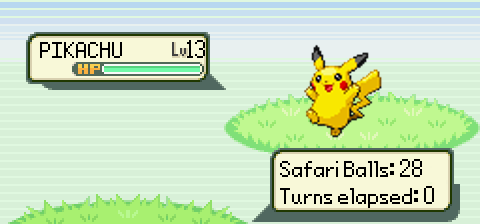


--- Stan Gry ---
Pozostałych Safari Balli: 28
Złapane Pokemony: 0
Aktualny Pokemon: PIKACHU (Lvl: 13)
  Szansa na złapanie: 0.32
  Szansa na ucieczkę: 0.19
  Tury do ucieczki: 7
  Upłynięte tury w spotkaniu: 0
----------------


KeyboardInterrupt: Interrupted by user

In [12]:
print("--- Tryb interaktywnego renderowania ---")
print("Wpisz numer akcji i naciśnij Enter:")
print("0: CATCH (Rzuć Safari Ballem)")
print("1: ROCK (Rzuć kamieniem)")
print("2: BAIT (Rzuć przynętę)")
print("---------------------------------------")

env_interactive = SafariZoneEnv(render_mode='rgb_array')  # Użyj renderowania graficznego
observation, info = env_interactive.reset()

done = False
while not done:
    clear_output(wait=True)  # Wyczyść poprzednią klatkę w Jupyterze

    # Wyświetl aktualną klatkę gry
    frame = env_interactive.render()
    if frame is not None:
        display(Image.fromarray(frame))
    else:
        print("Błąd renderowania klatki.")
        break  # Przerwij, jeśli renderowanie się nie powiedzie

    # Wyświetl aktualny stan tekstowy
    print(f"\n--- Stan Gry ---")
    print(f"Pozostałych Safari Balli: {env_interactive.safari_balls}")
    print(f"Złapane Pokemony: {env_interactive.caught_pokemon_count}")
    if env_interactive.current_pokemon:
        print(f"Aktualny Pokemon: {env_interactive.current_pokemon.pokemon_type.pokemon_name.upper()} (Lvl: {env_interactive.current_pokemon.level})")
        print(f"  Szansa na złapanie: {env_interactive.current_pokemon.current_catch_rate:.2f}")
        print(f"  Szansa na ucieczkę: {env_interactive.current_pokemon.current_escape_rate:.2f}")
        print(f"  Tury do ucieczki: {env_interactive.current_pokemon.remaining_turns}")
        print(f"  Upłynięte tury w spotkaniu: {env_interactive.current_pokemon.turns_elapsed_in_encounter}")
    else:
        print("Brak aktywnego Pokemona.")
    print("----------------")


    try:
        action_input = input("Twoja akcja (0:CATCH, 1:ROCK, 2:BAIT): ")
        action = int(action_input)
        if action not in [0, 1, 2]:
            print("Nieprawidłowa akcja. Wybierz 0, 1 lub 2.")
            time.sleep(1)
            continue
    except ValueError:
        print("Nieprawidłowy input. Wpisz liczbę.")
        time.sleep(1)
        continue

    observation, reward, terminated, truncated, info = env_interactive.step(action)
    done = terminated or truncated

    # Krótka pauza, żeby zobaczyć zmianę
    time.sleep(0.5)

print("\n--- Gra zakończona! ---")
print(f"Całkowita liczba złapanych Pokémonów: {env_interactive.caught_pokemon_count}")
print(f"Ostateczny stan: {info}")

env_interactive.close()

# Sprawdzenie wydajności losowego agenta

Sprawdzanie jak radzi sobie losowy agent w stworzonym środowisku.

In [13]:
print("--- Empiryczne sprawdzenie wydajności losowego agenta ---")

# Liczba epizodów do symulacji
num_simulations = 1_000_000

# Listy do przechowywania wyników
random_rewards = []
random_caught_pokemon = []

# Utworzenie środowiska dla symulacji
# Ustawiamy render_mode na None, żeby nie spowalniać symulacji graficznym renderowaniem
env_random_agent = SafariZoneEnv(render_mode=None)

for i in range(num_simulations):
    observation, info = env_random_agent.reset()
    done = False
    current_episode_reward = 0
    current_episode_caught = 0  # Śledzimy złapane Pokemony w bieżącym epizodzie

    while not done:
        # Agent podejmuje losową akcję (0: CATCH, 1: ROCK, 2: BAIT)
        action = env_random_agent.action_space.sample()

        observation, reward, terminated, truncated, info = env_random_agent.step(action)
        done = terminated or truncated

        current_episode_reward += reward
        # Aktualizuj liczbę złapanych Pokémonów z info, które jest zwracane przy zakończeniu epizodu
        # lub w każdym kroku, jeśli środowisko tak zwraca (u nas info['caught_pokemon_total'])
        current_episode_caught = info['caught_pokemon_total']

    random_rewards.append(current_episode_reward)
    random_caught_pokemon.append(current_episode_caught)

    if (i + 1) % 100 == 0:
        print(f"Zakończono {i + 1}/{num_simulations} symulacji.")

# Obliczanie i wyświetlanie statystyk
avg_random_reward = np.mean(random_rewards)
std_random_reward = np.std(random_rewards)
avg_random_caught = np.mean(random_caught_pokemon)
std_random_caught = np.std(random_caught_pokemon)

print("\n--- Wyniki dla losowego agenta ---")
print(f"Liczba symulacji: {num_simulations}")
print(f"Średnia całkowita nagroda na epizod: {avg_random_reward:.2f} (Std Dev: {std_random_reward:.2f})")
print(f"Średnia liczba złapanych Pokémonów na epizod: {avg_random_caught:.2f} (Std Dev: {std_random_caught:.2f})")
print(f"Maksymalna nagroda w epizodzie: {np.max(random_rewards):.2f}")
print(f"Minimalna nagroda w epizodzie: {np.min(random_rewards):.2f}")
print(f"Maksymalna liczba złapanych Pokémonów w epizodzie: {int(np.max(random_caught_pokemon))}")
print(f"Minimalna liczba złapanych Pokémonów w epizodzie: {int(np.min(random_caught_pokemon))}")

env_random_agent.close()
print("\nSymulacja losowego agenta zakończona.")

print("\n--- Generowanie wykresów Plotly dla losowego agenta ---")

# Wykres rozkładu nagród dla losowego agenta
fig_random_rewards = go.Figure(data=[
    go.Histogram(
        x=random_rewards,
        name='Nagrody Losowego Agenta',
        marker_color='skyblue',
        opacity=0.7,
        xbins=dict(size=10)  # Rozmiar przedziałów
    )
])
fig_random_rewards.update_layout(
    title_text=f"Rozkład całkowitych nagród na epizod (Losowy Agent, {num_simulations} epizodów)",
    xaxis_title_text="Całkowita Nagroda w Epizodzie",
    yaxis_title_text="Częstość",
    bargap=0.05  # Odstęp między słupkami
)
fig_random_rewards.write_html("random_agent_rewards_distribution.html")
print("Wykres rozkładu nagród losowego agenta został zapisany do 'random_agent_rewards_distribution.html'")

# Wykres rozkładu złapanych Pokémonów dla losowego agenta
fig_random_caught = go.Figure(data=[
    go.Histogram(
        x=random_caught_pokemon,
        name='Złapane Pokemony Losowego Agenta',
        marker_color='lightcoral',
        opacity=0.7,
        nbinsx=int(np.max(random_caught_pokemon)) + 1 if random_caught_pokemon else 1,  # Jeden słupek na każdą możliwą liczbę złapanych Pokémonów
        xbins=dict(start=0, end=int(np.max(random_caught_pokemon)) + 0.5, size=1)
    )
])
fig_random_caught.update_layout(
    title_text=f"Rozkład liczby złapanych Pokémonów na epizod (Losowy Agent, {num_simulations} epizodów)",
    xaxis_title_text="Liczba Złapanych Pokémonów",
    yaxis_title_text="Częstość",
    bargap=0.05
)
fig_random_caught.write_html("random_agent_caught_distribution.html")
print("Wykres rozkładu złapanych Pokémonów losowego agenta został zapisany do 'random_agent_caught_distribution.html'")

print("\nGenerowanie wykresów zakończone.")

--- Empiryczne sprawdzenie wydajności losowego agenta ---
Zakończono 100/1000000 symulacji.
Zakończono 200/1000000 symulacji.
Zakończono 300/1000000 symulacji.
Zakończono 400/1000000 symulacji.
Zakończono 500/1000000 symulacji.
Zakończono 600/1000000 symulacji.
Zakończono 700/1000000 symulacji.
Zakończono 800/1000000 symulacji.
Zakończono 900/1000000 symulacji.
Zakończono 1000/1000000 symulacji.
Zakończono 1100/1000000 symulacji.
Zakończono 1200/1000000 symulacji.
Zakończono 1300/1000000 symulacji.
Zakończono 1400/1000000 symulacji.
Zakończono 1500/1000000 symulacji.
Zakończono 1600/1000000 symulacji.
Zakończono 1700/1000000 symulacji.
Zakończono 1800/1000000 symulacji.
Zakończono 1900/1000000 symulacji.
Zakończono 2000/1000000 symulacji.
Zakończono 2100/1000000 symulacji.
Zakończono 2200/1000000 symulacji.
Zakończono 2300/1000000 symulacji.
Zakończono 2400/1000000 symulacji.
Zakończono 2500/1000000 symulacji.
Zakończono 2600/1000000 symulacji.
Zakończono 2700/1000000 symulacji.
Zakońc